<a href="https://colab.research.google.com/github/NavinMundhra/07_video_game_sales/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
## Overview
The gaming industry is certainly one of the thriving industries of the modern age and one of those that are most influenced by the advancement in technology. With the availability of technologies like AR/VR in consumer products like gaming consoles and even smartphones, the gaming sector shows great potential. In this hackathon, you as a data scientist must use your analytical skills to predict the sales of video games depending on given factors. Given are 8 distinguishing factors that can influence the sales of a video game. Your objective as a data scientist is to build a machine learning model that can accurately predict the sales in millions of units for a given game.

## Evaluation

The leaderboard is evaluated using RMSE for the participant’s submission.

# Imports & Data Exploration

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as prep


FILEPATH = '/content/drive/My Drive/Colab Notebooks/proj_6 - predict_video_game_sales/Data/'

In [ ]:
train = pd.read_csv(FILEPATH+'Train.csv')
test = pd.read_csv(FILEPATH+'Test.csv')
sample = pd.read_csv(FILEPATH+'Sample_Submission.csv')

df = pd.concat([train.drop('ID', axis=1), test.drop('ID', axis=1)], keys=['train', 'test'])
df

CONSOLE  YEAR  ... USER_POINTS SalesInMillions
train 0         ds  2008  ...    0.303704        1.779257
      1        wii  2012  ...    1.640000        0.215050
      2         pc  2019  ...    0.006410        0.534402
      3        ps2  2002  ...    0.326923        1.383964
      4        ps3  2013  ...    0.032579        0.082671
...            ...   ...  ...         ...             ...
test  1498     ps2  2004  ...    0.192308             NaN
      1499      ds  2007  ...    0.625000             NaN
      1500    xone  2016  ...    0.333333             NaN
      1501      ps  2002  ...    0.690000             NaN
      1502      pc  2010  ...    0.007629             NaN

[5009 rows x 8 columns]

In [ ]:
df['cp_whole'] = np.fix(df['CRITICS_POINTS'])
df['cp_frac'] = df['CRITICS_POINTS'] - np.fix(df['CRITICS_POINTS'])
df['up_whole'] = np.fix(df['USER_POINTS'])
df['up_frac'] = df['USER_POINTS'] - np.fix(df['USER_POINTS'])
df['up_frac_round'] = np.round(df['up_frac'], 3)
df['cp_frac_round'] = np.round(df['cp_frac'], 3)
df['YEAR_cat'] = pd.cut(df['YEAR'], bins = [1980, 1990, 2000, 2010, 2020], labels = ['1_d', '2_d', '3_d', '4_d']).astype('str')
df['unique_rating_per_publisher'] = df.groupby('PUBLISHER')['RATING'].transform('nunique')
df['unique_console_per_publisher'] = df.groupby('PUBLISHER')['CONSOLE'].transform('nunique')
df['unique_category_per_publisher'] = df.groupby('PUBLISHER')['CATEGORY'].transform('nunique')
# df['std_cp_publisher'] = df.groupby('PUBLISHER')['CRITICS_POINTS'].transform('std')
# df['std_cp_console'] = df.groupby('CONSOLE')['CRITICS_POINTS'].transform('std')
# df['std_cp_rating'] = df.groupby('RATING')['CRITICS_POINTS'].transform('std')
# df['std_cp_cate'] = df.groupby('CATEGORY')['CRITICS_POINTS'].transform('std')
df['YEAR'] = df['YEAR'].astype('str')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5009 entries, ('train', 0) to ('test', 1502)
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CONSOLE                        5009 non-null   object 
 1   YEAR                           5009 non-null   object 
 2   CATEGORY                       5009 non-null   object 
 3   PUBLISHER                      5009 non-null   object 
 4   RATING                         5009 non-null   object 
 5   CRITICS_POINTS                 5009 non-null   float64
 6   USER_POINTS                    5009 non-null   float64
 7   SalesInMillions                3506 non-null   float64
 8   cp_whole                       5009 non-null   float64
 9   cp_frac                        5009 non-null   float64
 10  up_whole                       5009 non-null   float64
 11  up_frac                        5009 non-null   float64
 12  up_frac_round              

In [ ]:
df.describe()

,CRITICS_POINTS,USER_POINTS,SalesInMillions,cp_whole,cp_frac,up_whole,up_frac,up_frac_round,cp_frac_round,unique_rating_per_publisher,unique_console_per_publisher,unique_category_per_publisher,std_cp_console,std_cp_cate
count,5009.000000,5009.000000,3506.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000
mean,3.815513,0.404865,2.171021,3.350769,0.464744,0.126572,0.278293,0.278297,0.464739,3.827111,11.453584,9.855061,2.973259,3.106264
std,3.194413,0.455591,2.495396,3.221170,0.288730,0.356857,0.260574,0.260572,0.288732,0.789341,4.803226,3.135478,0.636261,0.472782
min,0.568966,0.000341,0.001524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.822069,2.308502
25%,1.738095,0.067778,0.965679,1.000000,0.214286,0.000000,0.061240,0.061000,0.214000,4.000000,7.000000,9.000000,2.589157,2.906001
50%,2.785714,0.231579,1.866140,2.000000,0.460000,0.000000,0.196970,0.197000,0.460000,4.000000,13.000000,12.000000,2.880963,3.309060
75%,4.625000,0.583333,2.792029,4.000000,0.714286,0.000000,0.435000,0.435000,0.714000,4.000000,16.000000,12.000000,3.366722,3.340823
max,23.250000,2.375000,84.226041,23.000000,0.989583,2.000000,0.988889,0.989000,0.990000,5.000000,16.000000,12.000000,5.535948,4.026902


In [ ]:
target = 'SalesInMillions'
catfeat, numfeat = list(df.select_dtypes(exclude = np.number)), list(df.select_dtypes(include = np.number)) 
numfeat.remove(target)

In [ ]:
df[numfeat].skew()

CRITICS_POINTS                   2.299211
USER_POINTS                      1.607630
cp_whole                         2.289793
cp_frac                          0.027216
up_whole                         2.785447
up_frac                          0.948700
up_frac_round                    0.948686
cp_frac_round                    0.027209
unique_rating_per_publisher     -1.896739
unique_console_per_publisher    -0.664231
unique_category_per_publisher   -1.519410
std_cp_console                   0.920445
std_cp_cate                     -0.505016
dtype: float64

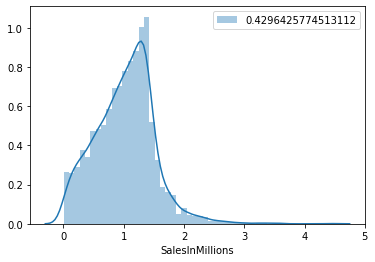

In [ ]:
# sns.distplot(np.log1p(df.xs('train')[target]), label=np.log1p(df.xs('train')[target]).skew()); plt.legend(); plt.show()
df.xs('train')[target] = np.log1p(df.xs('train')[target])

# DATA PREPARATION

In [ ]:
for col in numfeat:
    df[col] = stats.boxcox(1+df[col], stats.boxcox_normmax(1+df[col]))
df[numfeat].skew()

minmax = prep.MinMaxScaler()
df[numfeat] = minmax.fit_transform(df[numfeat])

In [ ]:
df = pd.get_dummies(df)

# le = prep.LabelEncoder()
# for col in catfeat:
#     df[col] = le.fit_transform(df[col])

X = df.xs('train').drop(target, axis=1); y = df.xs('train')[target]; X_test = df.xs('test').drop(target, axis=1)
X.shape, y.shape, X_test.shape

((3506, 311), (3506,), (1503, 311))

In [ ]:
y.head()

0    1.022184
1    0.194785
2    0.428140
3    0.868765
4    0.079431
Name: SalesInMillions, dtype: float64

# MODELS

# LASSO

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

kf = KFold(15, random_state=100, shuffle=True)

lassr, scores = Lasso(random_state=100), list()

for train, test in kf.split(X,y):
    xtrain, ytrain = X.loc[train], y.loc[train]
    xtest, ytest = X.loc[test], y.loc[test]

    lassr.fit(xtrain, ytrain)
    ypred = lassr.predict(xtest)

    temp = mean_squared_error(ypred,ytest,squared=False)
    scores.append(temp)

scoresd['lasso'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['lasso'])

CV( 15 ) score:  0.49086272149388777


In [ ]:
lassr

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

# ELASTICNET

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

enetr, scores = SGDRegressor(early_stopping=True, verbose=False, l1_ratio=0.5, validation_fraction=0.3), list()

for train, test in kf.split(X,y):
    xtrain, ytrain = X.loc[train], y.loc[train]
    xtest, ytest = X.loc[test], y.loc[test]

    enetr.fit(xtrain, ytrain)
    ypred = enetr.predict(xtest)

    temp = mean_squared_error(ypred,ytest,squared=False)
    scores.append(temp)

scoresd['elastic_net'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['elastic_net'])

CV( 15 ) score:  0.47634466239241857


In [ ]:
enetr.get_params

<bound method BaseEstimator.get_params of SGDRegressor(alpha=0.0001, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.5,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.3, verbose=False,
             warm_start=False)>

## LIGHTGBM

In [ ]:
import lightgbm as lgb

lgbr, scores, scoresd = lgb.LGBMRegressor(learning_rate = 0.03, n_estimators=2500, num_leaves=20, reg_alpha=0.3,
                                          max_depth=6, reg_lambda=0.4, silent=True), list(), dict()

for train, test in kf.split(X,y):
    xtrain, ytrain = X.loc[train], y.loc[train]
    xtest, ytest = X.loc[test], y.loc[test]

    lgbr.fit(xtrain, ytrain, early_stopping_rounds=100, verbose=False, eval_metric='rmse', eval_set=(xtest, ytest))
    ypred = lgbr.predict(xtest)

    temp = mean_squared_error(ypred,ytest,squared=False)
    scores.append(temp)

scoresd['baseline_lgb'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['baseline_lgb'])

CV( 15 ) score:  0.4450045782471692


In [ ]:
lgbr

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2500, n_jobs=-1, num_leaves=20, objective=None,
              random_state=None, reg_alpha=0.3, reg_lambda=0.4, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

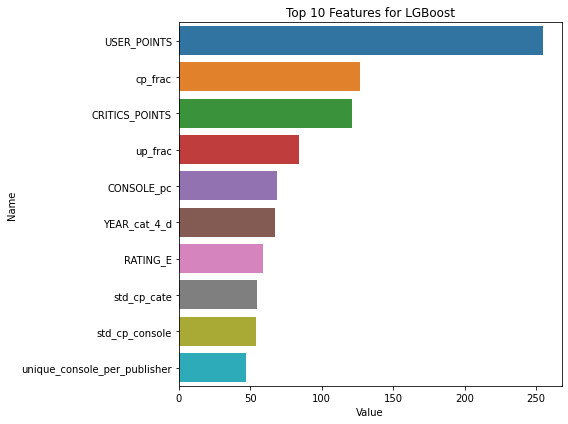

In [ ]:
imp = pd.concat([pd.Series(lgbr.feature_importances_), pd.Series(list(X.columns))], keys = ['Value', 'Name'], axis=1)

plt.figure(figsize=(8,6)); sns.barplot(x='Value', y='Name', data= imp.sort_values(by='Value', ascending=False)[:10])
plt.title('Top 10 Features for LGBoost'); plt.tight_layout()

## XGBOOST

In [ ]:
import xgboost as xgb

xgbr, scores = xgb.XGBRegressor(silent=True), list()

for train, test in kf.split(X,y):
    xtrain, ytrain = X.loc[train], y.loc[train]
    xtest, ytest = X.loc[test], y.loc[test]

    xgbr.fit(xtrain,ytrain)
    ypred = xgbr.predict(xtest)

    temp = mean_squared_error(ypred,ytest, squared=False)
    scores.append(temp)
    
scoresd['baseline_XGB'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['baseline_XGB']);

CV( 15 ) score:  0.44900855155860514


In [ ]:
xgbr

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

## CATBOOST

In [ ]:
# ! pip install catboost
import catboost
from catboost import CatBoostRegressor

cbr, scores = CatBoostRegressor(silent=True), list()

for train, test in kf.split(X,y):
    xtrain, ytrain = X.loc[train], y.loc[train]
    xtest, ytest = X.loc[test], y.loc[test]

    cbr.fit(xtrain,ytrain, )
    ypred = cbr.predict(xtest)

    temp = mean_squared_error(ypred, ytest, squared=False)
    scores.append(temp)
    
scoresd['baseline_CatBoost'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['baseline_CatBoost']);

CV( 15 ) score:  0.45261551587666243


In [ ]:
cbr.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.04820200055837631,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'random_seed': 0,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.800000011920929,
 'task_type': 'CPU',
 'use_best_model': False}

## BLENDING & SUBMISSION

In [ ]:
## FITTING
lgbr = lgb.LGBMRegressor()
lgbm = lgbr.fit(X,y)
xgbm = xgbr.fit(X,y)
cbrm = cbr.fit(X,y)
enetm = enetr.fit(X,y)
lasm = lassr.fit(X,y)

## PREDICTIONS
lgbpred = lgbm.predict(X_test)
xgbpred = xgbm.predict(X_test)
cbrpred = cbrm.predict(X_test)
enetpred = enetm.predict(X_test)
lasspred = lasm.predict(X_test)

In [ ]:
scoresd

{'baseline_CatBoost': 0.45261551587666243,
 'baseline_XGB': 0.44900855155860514,
 'baseline_lgb': 0.4450045782471692,
 'elastic_net': 0.47634466239241857,
 'lasso': 0.49086272149388777}

In [ ]:
## BLENDING

# Y_pred = 0.70*lgb_Y_pred + 0.30*xgb_Y_pred
# Y_pred = np.expm1(xgb_Y_pred)

Y_pred = np.expm1(0.6*lgbpred+0.4*xgbpred)

Y_pred

array([1.65013739, 2.04860954, 2.84216006, ..., 1.40145455, 1.86206174,
       1.84852465])

In [ ]:
## CREATING SUBMISSION FILE

sample.iloc[:,0] = np.round(Y_pred, 4); sample.to_csv(FILEPATH+'/blend_06.csv', index=False)
best = pd.read_csv(FILEPATH+'/blend_01.csv')

In [ ]:
best

,SalesInMillions
0,1.620
1,1.768
2,2.663
3,1.821
4,1.983
...,...
1498,1.688
1499,1.199
1500,1.254
1501,1.757


In [ ]:
sample.iloc[:,0] = best.iloc[:,0]*0.995; sample.to_csv(FILEPATH+'/blend_07.csv', index=False)

0       1.611900
1       1.759160
2       2.649685
3       1.811895
4       1.973085
          ...   
1498    1.679560
1499    1.193005
1500    1.247730
1501    1.748215
1502    1.866620
Name: SalesInMillions, Length: 1503, dtype: float64